# 02 - Randomized Experiments and Stats Review
 
 
## Brute Force Independence with Randomization


## An A/B Testing Example
 

In [1]:
import polars as pl

# pd.set_option('display.max_rows', 5)

In [2]:
import polars as pl  # for data manipulation
import numpy as np  # for numerical computation

df = pl.read_csv("./data/cross_sell_email.csv")
print(df)

shape: (323, 4)
┌────────┬──────────────────┬─────┬────────────┐
│ gender ┆ cross_sell_email ┆ age ┆ conversion │
│ ---    ┆ ---              ┆ --- ┆ ---        │
│ i64    ┆ str              ┆ i64 ┆ i64        │
╞════════╪══════════════════╪═════╪════════════╡
│ 0      ┆ short            ┆ 15  ┆ 0          │
│ 1      ┆ short            ┆ 27  ┆ 0          │
│ 1      ┆ long             ┆ 17  ┆ 0          │
│ 1      ┆ long             ┆ 34  ┆ 0          │
│ 1      ┆ no_email         ┆ 14  ┆ 0          │
│ …      ┆ …                ┆ …   ┆ …          │
│ 0      ┆ long             ┆ 18  ┆ 0          │
│ 1      ┆ no_email         ┆ 16  ┆ 0          │
│ 0      ┆ no_email         ┆ 15  ┆ 0          │
│ 1      ┆ no_email         ┆ 16  ┆ 0          │
│ 1      ┆ long             ┆ 24  ┆ 1          │
└────────┴──────────────────┴─────┴────────────┘


In [3]:
print(df.group_by("cross_sell_email").mean())

shape: (3, 4)
┌──────────────────┬──────────┬───────────┬────────────┐
│ cross_sell_email ┆ gender   ┆ age       ┆ conversion │
│ ---              ┆ ---      ┆ ---       ┆ ---        │
│ str              ┆ f64      ┆ f64       ┆ f64        │
╞══════════════════╪══════════╪═══════════╪════════════╡
│ no_email         ┆ 0.542553 ┆ 20.489362 ┆ 0.042553   │
│ long             ┆ 0.550459 ┆ 21.752294 ┆ 0.055046   │
│ short            ┆ 0.633333 ┆ 20.991667 ┆ 0.125      │
└──────────────────┴──────────┴───────────┴────────────┘


In [4]:
X = ["gender", "age"]

mu = df.group_by("cross_sell_email").agg(pl.mean(X))
var = df.group_by("cross_sell_email").agg(pl.var(X))

# norm_diff = (
#     (mu - mu.filter(pl.col("cross_sell_email") == "no_email"))
#     / np.sqrt((var + var.filter(pl.col("cross_sell_email") == "no_email")) / 2)
# )
# norm_diff

## The Ideal Experiment
 

 
## The Most Dangerous Equation


In [5]:
import warnings
warnings.filterwarnings('ignore')

import polars as pl
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from cycler import cycler
import matplotlib

default_cycler = (cycler(color=['0.1', '0.5', '1.0']))

color = ['0.3', '0.5', '0.7', '0.9']
linestyle = ['-', '--', ':', '-.']
marker = ['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

matplotlib.rcParams.update({'font.size': 18})

In [6]:
df = pl.read_csv("data/enem_scores.csv")
print(df.sort(by="avg_score", descending=True).head(10))

shape: (10, 4)
┌──────┬───────────┬────────────────────┬───────────┐
│ year ┆ school_id ┆ number_of_students ┆ avg_score │
│ ---  ┆ ---       ┆ ---                ┆ ---       │
│ i64  ┆ i64       ┆ i64                ┆ f64       │
╞══════╪═══════════╪════════════════════╪═══════════╡
│ 2007 ┆ 33062633  ┆ 68                 ┆ 82.97     │
│ 2007 ┆ 33065403  ┆ 172                ┆ 82.04     │
│ 2005 ┆ 33062633  ┆ 59                 ┆ 81.89     │
│ 2005 ┆ 33065403  ┆ 177                ┆ 81.66     │
│ 2007 ┆ 29342880  ┆ 43                 ┆ 80.32     │
│ 2007 ┆ 33152314  ┆ 14                 ┆ 79.82     │
│ 2007 ┆ 33065250  ┆ 80                 ┆ 79.67     │
│ 2007 ┆ 22025740  ┆ 144                ┆ 79.52     │
│ 2007 ┆ 31311723  ┆ 222                ┆ 79.41     │
│ 2007 ┆ 33087679  ┆ 210                ┆ 79.38     │
└──────┴───────────┴────────────────────┴───────────┘


Text(0.5, 1.0, 'Number of Students of 1% Top Schools (Right)')

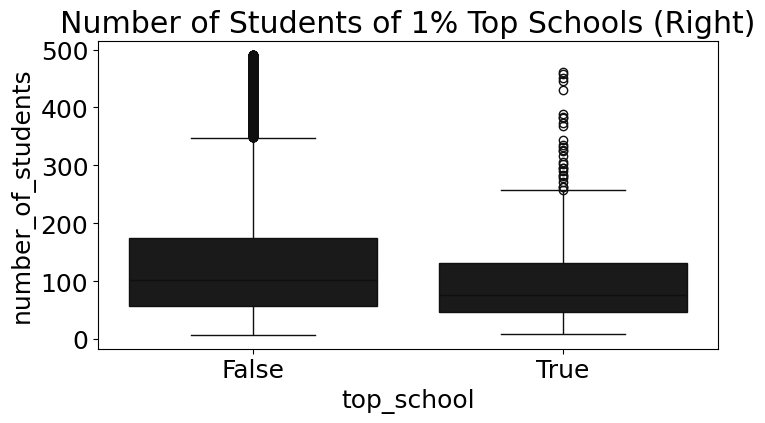

In [7]:
plot_data = (
    df
    .with_columns(
        top_school=pl.col("avg_score") >= pl.col("avg_score").quantile(.99)
    )
    .select(["top_school", "number_of_students"])
    .filter(pl.col("number_of_students") < pl.col("number_of_students").quantile(.98))  # remove outliers
)

plt.figure(figsize=(8, 4))
ax = sns.boxplot(x="top_school", y="number_of_students", data=plot_data)

plt.title("Number of Students of 1% Top Schools (Right)")

Text(0.5, 1.0, 'ENEM Score by Number of Students in the School')

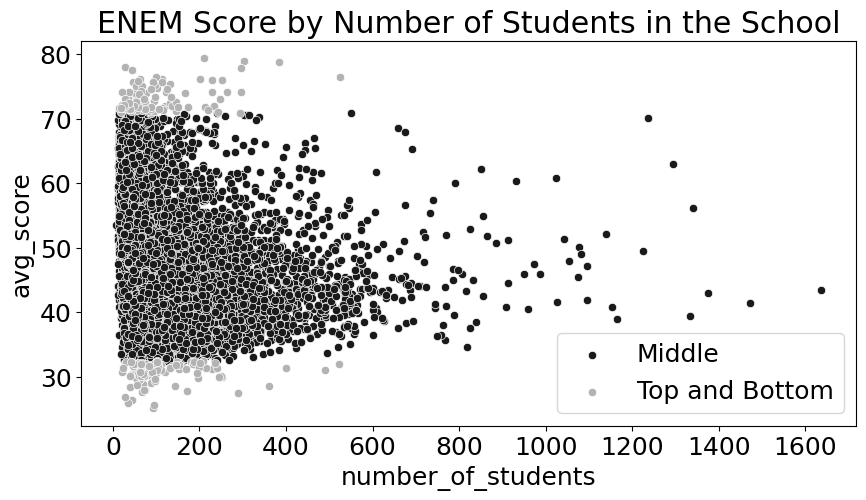

In [8]:
q_99 = pl.col("avg_score").quantile(.99)
q_01 = pl.col("avg_score").quantile(.01)

plot_data = (
    df
    .sample(10000)
    .with_columns(
        group=pl.when((pl.col("avg_score") > q_99) | (pl.col("avg_score") < q_01))
            .then(pl.lit("Top and Bottom"))
            .otherwise(pl.lit("Middle"))
    )
)
plt.figure(figsize=(10, 5))
sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.filter(pl.col("group") == "Middle"), label="Middle")
ax = sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.filter(pl.col("group") != "Middle"), color="0.7", label="Top and Bottom")

plt.title("ENEM Score by Number of Students in the School")

##  The Standard Error of Our Estimates
 

In [9]:
data = pl.read_csv("./data/cross_sell_email.csv")

short_email = data.filter(pl.col("cross_sell_email") == "short")["conversion"]
long_email = data.filter(pl.col("cross_sell_email") == "long")["conversion"]
email = data.filter(pl.col("cross_sell_email") != "no_email")["conversion"]
no_email = data.filter(pl.col("cross_sell_email") == "no_email")["conversion"]

print(data.groupby("cross_sell_email").count())

shape: (3, 2)
┌──────────────────┬───────┐
│ cross_sell_email ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ short            ┆ 120   │
│ long             ┆ 109   │
│ no_email         ┆ 94    │
└──────────────────┴───────┘


In [10]:
def se(y: pl.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Long Email:", se(long_email))
print("SE for Short Email:", se(short_email))

SE for Long Email: 0.02194602460918551
SE for Short Email: 0.030316953129541618


## Confidence Intervals
 

In [11]:
n = 100
conv_rate = 0.08

def run_experiment():
    return np.random.binomial(1, conv_rate, size=n)

np.random.seed(42)

experiments = [run_experiment().mean() for _ in range(10000)]

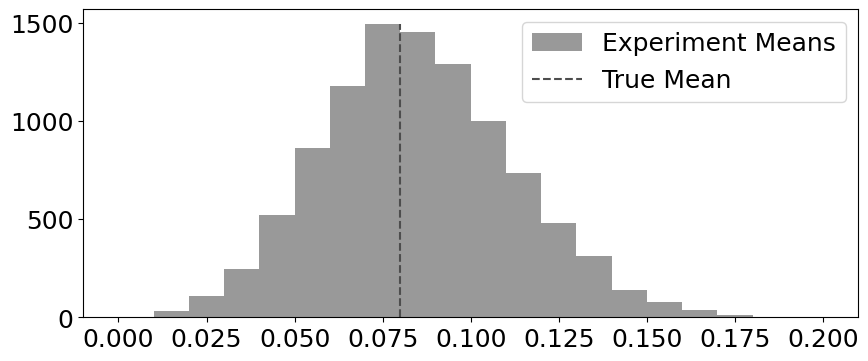

In [12]:
plt.figure(figsize=(10, 4))
freq, bins, img = plt.hist(experiments, bins=20, label="Experiment Means", color="0.6")
plt.vlines(conv_rate, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="0.3")
plt.legend()

(array([92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

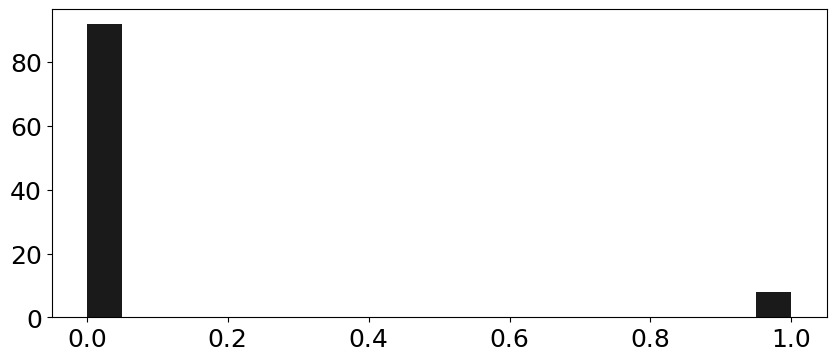

In [13]:
np.random.seed(42)
plt.figure(figsize=(10, 4))
plt.hist(np.random.binomial(1, 0.08, 100), bins=20)

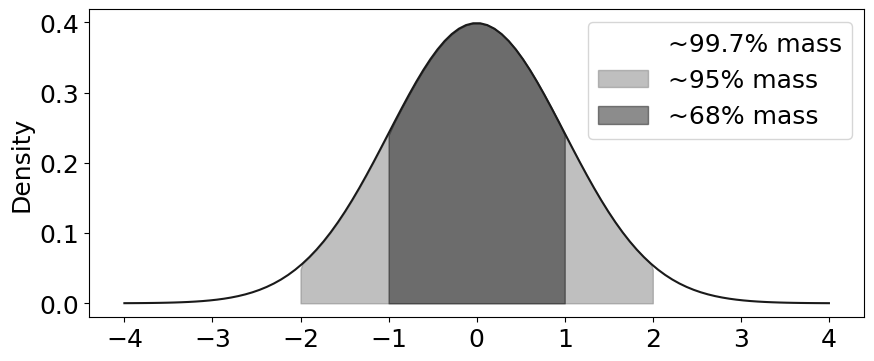

In [14]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10, 4))
plt.plot(x, y, linestyle="solid")
plt.fill_between(x.clip(-3, +3), 0, y, alpha=0.5, label="~99.7% mass", color="C2")
plt.fill_between(x.clip(-2, +2), 0, y, alpha=0.5, label="~95% mass", color="C1")
plt.fill_between(x.clip(-1, +1), 0, y, alpha=0.5, label="~68% mass", color="C0")
plt.ylabel("Density")
plt.legend()

In [15]:
exp_se = se(short_email)
exp_mu = short_email.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print("95% CI for Short Email: ", ci)

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)


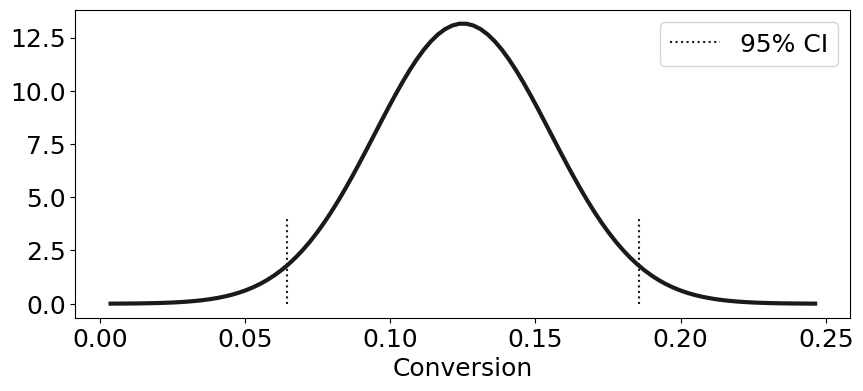

In [16]:
x = np.linspace(exp_mu - 4 * exp_se, exp_mu + 4 * exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10, 4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

In [17]:
from scipy import stats

z = np.abs(stats.norm.ppf((1 - 0.99) / 2))
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

In [18]:
stats.norm.ppf((1 - 0.99) / 2)

-2.5758293035489004

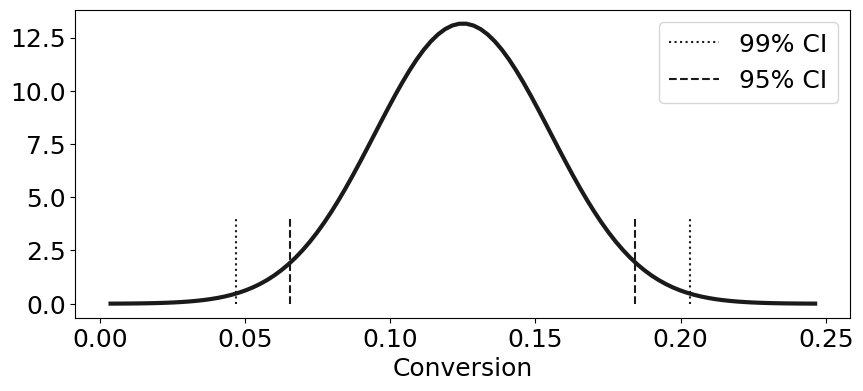

In [19]:
x = np.linspace(exp_mu - 4 * exp_se, exp_mu + 4 * exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10, 4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="99% CI")

ci_95 = (exp_mu - 1.96 * exp_se, exp_mu + 1.96 * exp_se)

plt.vlines(ci_95[1], ymin=0, ymax=4, ls="dashed")
plt.vlines(ci_95[0], ymin=0, ymax=4, ls="dashed", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

In [20]:
def ci(y: pl.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Short Email:", ci(short_email))
print("95% CI for Long Email:", ci(long_email))
print("95% CI for No Email:", ci(no_email))

95% CI for Short Email: (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email: (0.011153822341262012, 0.09893792077800405)
95% CI for No Email: (0.0006919679286838329, 0.08441441505003958)


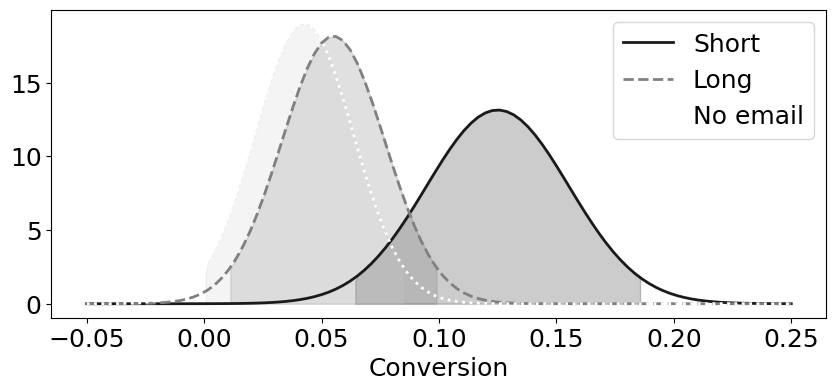

In [21]:
plt.figure(figsize=(10, 4))

x = np.linspace(-0.05, .25, 100)
short_dist = stats.norm.pdf(x, short_email.mean(), se(short_email))
plt.plot(x, short_dist, lw=2, label="Short", linestyle=linestyle[0])
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), 0, short_dist, alpha=0.2, color="0.0")

long_dist = stats.norm.pdf(x, long_email.mean(), se(long_email))
plt.plot(x, long_dist, lw=2, label="Long", linestyle=linestyle[1])
plt.fill_between(x.clip(ci(long_email)[0], ci(long_email)[1]), 0, long_dist, alpha=0.2, color="0.4")

no_email_dist = stats.norm.pdf(x, no_email.mean(), se(no_email))
plt.plot(x, no_email_dist, lw=2, label="No email", linestyle=linestyle[2])
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 0, no_email_dist, alpha=0.2, color="0.8")

plt.xlabel("Conversion")
plt.legend()

## Hypothesis Testing
 

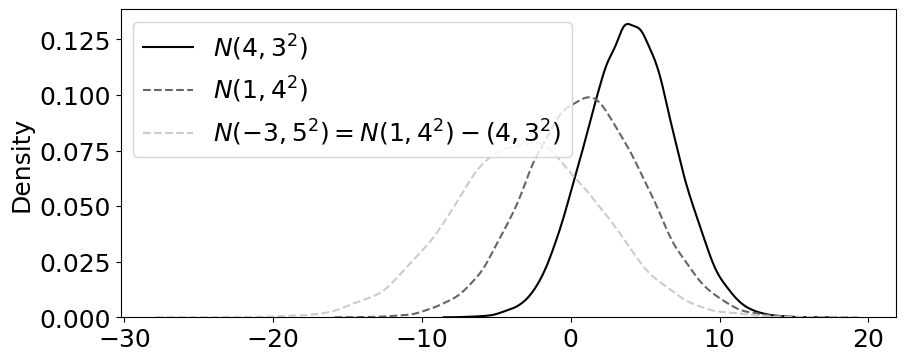

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1

plt.figure(figsize=(10,4))
sns.distplot(n1, hist=False, label="$N(4,3^2)$", color="0.0", kde_kws={"linestyle": linestyle[0]})
sns.distplot(n2, hist=False, label="$N(1,4^2)$", color="0.4", kde_kws={"linestyle": linestyle[1]})
sns.distplot(n_diff, hist=False,
             label=f"$N(-3, 5^2) = N(1,4^2) - (4,3^2)$", color="0.8", kde_kws={"linestyle": linestyle[1]})
plt.legend();

In [23]:
diff_mu = short_email.mean() - no_email.mean()
diff_se = np.sqrt(se(no_email) ** 2 + se(short_email) ** 2)

ci = (diff_mu - 1.96 * diff_se, diff_mu + 1.96 * diff_se)
print(f"95% CI for the differece (short email - no email):\n{ci}")

95% CI for the differece (short email - no email):
(0.010239808474398426, 0.15465380854687816)


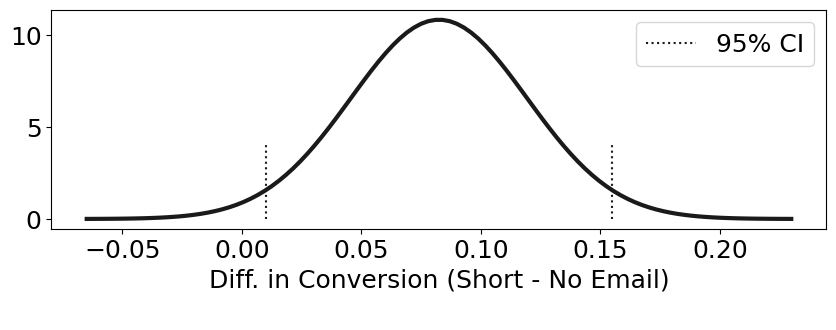

In [24]:
x = np.linspace(diff_mu - 4 * diff_se, diff_mu + 4 * diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)

plt.figure(figsize=(10, 3))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Diff. in Conversion (Short - No Email)\n")
plt.legend()
plt.subplots_adjust(bottom=0.15)



### Null Hypothesis


In [25]:
# shifting the CI
diff_mu_shifted =  short_email.mean() - no_email.mean() - 0.01
diff_se = np.sqrt(se(no_email) ** 2 + se(short_email) ** 2)

ci = (diff_mu_shifted - 1.96 * diff_se, diff_mu_shifted + 1.96 * diff_se)
print(f"95% CI 1% difference between (short email - no email):\n{ci}")

95% CI 1% difference between (short email - no email):
(0.00023980847439843134, 0.14465380854687815)



### Test Statistic


In [26]:
t_stat = (diff_mu - 0) / diff_se
t_stat

2.237951231871536


 
## P-values


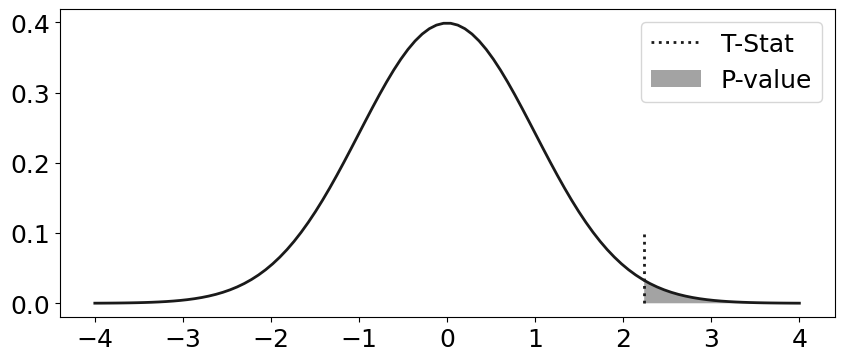

In [27]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10, 4))
plt.plot(x, y, lw=2)
plt.vlines(t_stat, ymin=0, ymax=0.1, ls="dotted", label="T-Stat", lw=2)
plt.fill_between(x.clip(t_stat), 0, y, alpha=0.4, label="P-value")
plt.legend()

In [28]:
print("P-value:", (1 - stats.norm.cdf(t_stat)) * 2)

P-value: 0.025224235562152142


## Power


In [29]:
stats.norm.cdf(0.84)

0.7995458067395503

## Sample Size Calculation


In [30]:
# in the book it is np.ceil(16 * no_email.std() ** 2 / 0.01), but it is missing the ** 2 in the denominator.
np.ceil(16 * (no_email.std() / 0.08) ** 2)

103.0

In [31]:
print(data.group_by("cross_sell_email").count())

shape: (3, 2)
┌──────────────────┬───────┐
│ cross_sell_email ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ short            ┆ 120   │
│ long             ┆ 109   │
│ no_email         ┆ 94    │
└──────────────────┴───────┘


## Key Ideas
